[Explanation Video](https://drive.google.com/file/d/1H9TCkZPHo6mwgnv3RYAss7BHQcXfyM_O/view?usp=share_link)
* video has few vocabulary errors due to anxiety (this is assignment 2 only)

In [1]:
#connecting to the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing required libraries

In [13]:
import os
import cv2
import shutil
import random
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tarfile

### Importing data from the Google drive

In [3]:
# Specify the path to the 'lfw.tgz' file in Google Drive
tgz_file_path = '/content/drive/MyDrive/EE782_data/lfw.tgz'

# Defining the destination directory in Google Drive where the contents will be extracted
dest_dir = '/content/drive/MyDrive/EE782_data/A2'

In [4]:
# Extract the contents of the 'lfw.tgz' file to the specified destination directory
with tarfile.open(tgz_file_path, 'r:gz') as tar:
    tar.extractall(dest_dir)

### Splitting the Data

In [ ]:
def split_data_by_person(dest_dir, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2):
    # Define the path to the 'lfw' directory
    lfw_dir = os.path.join(dest_dir, 'lfw')

    # List the subfolders (person names)
    subfolders = os.listdir(lfw_dir)

    # Shuffle the list of subfolders to randomize the order
    random.shuffle(subfolders)

    # Calculate the number of subfolders for each set
    total_subfolders = len(subfolders)
    train_count = int(train_ratio * total_subfolders)
    val_count = int(val_ratio * total_subfolders)

    # Define the paths for the new directories
    train_dir = os.path.join(dest_dir, 'train_data')
    val_dir = os.path.join(dest_dir, 'val_data')
    test_dir = os.path.join(dest_dir, 'test_data')

    # Create the new directories if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Move subfolders into the new directories
    for i, subfolder in enumerate(subfolders):
        source_path = os.path.join(lfw_dir, subfolder)
        if i < train_count:
            destination_path = os.path.join(train_dir, subfolder)
        elif i < train_count + val_count:
            destination_path = os.path.join(val_dir, subfolder)
        else:
            destination_path = os.path.join(test_dir, subfolder)

        shutil.copytree(source_path, destination_path)

    print("Data split into training, validation, and testing sets by person name.")

# Now splitting the data
# split_data_by_person(dest_dir)

### Image Data Loading and Preprocessing
- includes cropping and resizing

In [4]:
def load_data(data_directory):
    data = []
    labels = []

    label_to_person = {}
    person_folders = os.listdir(data_directory)

    for label, person in enumerate(person_folders):
        label_to_person[label] = person
        person_folder = os.path.join(data_directory, person)

        for image_file in os.listdir(person_folder):
            image_path = os.path.join(person_folder, image_file)

            img = Image.open(image_path)
            img = img.resize((100, 100))  # Resize the image to your desired size
            img = np.array(img) / 255.0  # Normalize pixel values to [0, 1]

            data.append(img)
            labels.append(label)

    return np.array(data), np.array(labels)

# Load train, validation, and test data
train_images, train_labels = load_data('/content/drive/MyDrive/EE782_data/A2/train_data')
validation_images, validation_labels = load_data('/content/drive/MyDrive/EE782_data/A2/val_data')
test_images, test_labels = load_data('/content/drive/MyDrive/EE782_data/A2/test_data')

### Shape Inspection of data and labels loaded

In [5]:
print(train_images.shape, test_images.shape, validation_images.shape)
print(train_labels.shape, test_labels.shape, validation_labels.shape)

(2449, 100, 100, 3) (860, 100, 100, 3) (1197, 100, 100, 3)
(2449,) (860,) (1197,)


### Reference for most of the code blocks from now:

**Siamese Contrastive** - [Keras](https://keras.io/examples/vision/siamese_contrastive/)
* Image similarity estimation using a Siamese Network with a contrastive loss


### Create pairs of images

In [6]:
def create_pairs(data, labels):
    # Get unique labels from the training data
    unique_labels = np.unique(labels)

    # Create indices for each label
    digit_indices = [np.where(labels == label)[0] for label in unique_labels]

    pairs = []
    labels = []
    num_classes = len(digit_indices)

    # Iterate over each class
    for d in range(num_classes):
        # Iterate over each instance of the current class
        for i in range(len(digit_indices[d])):
            # Create a positive pair with two instances from the same class
            z1, z2 = digit_indices[d][i], digit_indices[d][(i + 1) % len(digit_indices[d])]
            pairs += [[data[z1], data[z2]]]  # Positive pair
            labels += [1]  # Label for the positive pair

            # Create negative pairs with instances from different classes
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            while dn == d:
                inc = random.randrange(1, num_classes)
                dn = (d + inc) % num_classes

            z1, z2 = digit_indices[d][i], digit_indices[dn][random.randrange(len(digit_indices[dn]))]
            pairs += [[data[z1], data[z2]]]  # Negative pair
            labels += [0]  # Label for the negative pair

    # Convert pairs and labels to NumPy arrays
    return np.array(pairs), np.array(labels, dtype=np.float32)

# Create pairs and labels for the training, validation, and test data
train_pairs, train_labels = create_pairs(train_images, train_labels)  # Training data pairs
val_pairs, val_labels = create_pairs(validation_images, validation_labels)  # Validation data pairs
test_pairs, test_labels = create_pairs(test_images, test_labels)  # Test data pairs

Print the shapes of the training, test, and validation pairs
- train_pairs.shape: Shape of the training pairs, i.e., the number of pairs and dimensions per pair
- test_pairs.shape: Shape of the test pairs, indicating the number of pairs and dimensions per pair
- val_pairs.shape: Shape of the validation pairs, showing the number of pairs and dimensions per pair

In [7]:
print(train_pairs.shape,test_pairs.shape,val_pairs.shape)

(4898, 2, 100, 100, 3) (1720, 2, 100, 100, 3) (2394, 2, 100, 100, 3)


### Visualize pairs and their labels

In [8]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        # Display the pair of images side by side
        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            # If it's a test dataset, show true label and predicted value
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            # If it's not a test dataset, show the label
            ax.set_title("Label: {}".format(labels[i]))

    if test:
      # For the test dataset, adjust layout for a larger title
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        # For other datasets, set a normal layout
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

Visualize a subset of training pairs and their labels
- pairs_train[:-1]: The subset of pairs from the training set, excluding the last pair
- labels_train[:-1]: The labels corresponding to the pairs, excluding the label of the last pair
- to_show=4: Display 4 pairs
- num_col=4: Arrange the pairs in a grid with 4 columns

Inspect test pairs

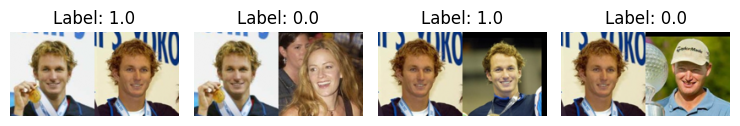

In [9]:
visualize(train_pairs[:-1], train_labels[:-1], to_show=4, num_col=4)

Inspect validation pairs

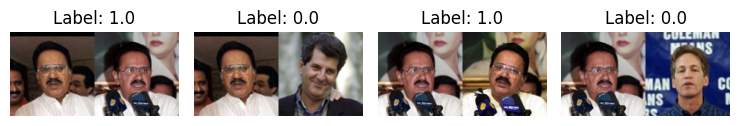

In [10]:
visualize(val_pairs[:-1], val_labels[:-1], to_show=4, num_col=4)

Inspect test pairs

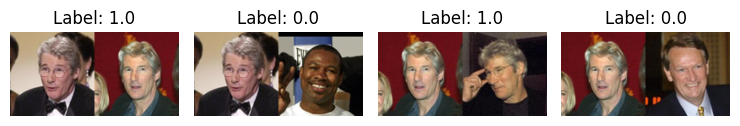

In [11]:
visualize(test_pairs[:-1], test_labels[:-1], to_show=4, num_col=4)

## Defining the main Model

**euclidean_distance**:

Calculates the Euclidean distance between two vectors.

**Arguments:**

* `vects`: List containing two tensors of the same length.

**Returns:**

* A tensor containing the Euclidean distance (as a floating point value) between the vectors.


In [21]:
# Import necessary modules and functions
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

# Define a function to calculate Euclidean distance between two vectors
def euclidean_distance(vects):
    # Unpack the input vectors x and y
    x, y = vects

    # Calculate the sum of squares of the differences between x and y
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)

    # Calculate the square root of the sum_square with epsilon for stability
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

# Define a function to create the embedding model
def create_embedding_model(input_shape):
    # Define the input layer with the specified input shape
    input = layers.Input(input_shape)

    # Apply a 2D convolutional layer with 32 filters and ReLU activation
    x = layers.Conv2D(32, (3, 3), activation="relu")(input)

    # Apply MaxPooling2D to downsample the feature maps
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Apply a second 2D convolutional layer with 64 filters and ReLU activation
    x = layers.Conv2D(64, (3, 3), activation="relu")(x)

    # Apply MaxPooling2D again to downsample further
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Flatten the feature maps into a vector
    x = layers.Flatten()(x)

    # Apply a dense layer with 256 units and ReLU activation
    x = layers.Dense(256, activation="relu")(x)

    # Apply BatchNormalization for normalization
    x = layers.BatchNormalization()(x)

    # Apply a final dense layer with 128 units and ReLU activation
    x = layers.Dense(128, activation="relu")(x)

    # Create the embedding model with input and output
    return keras.Model(input, x)

# Define a function to create the Siamese model
def create_siamese_model(embedding_model):
    # Define input layers for two input images
    input_1 = layers.Input(embedding_model.input_shape[1:])
    input_2 = layers.Input(embedding_model.input_shape[1:])

    # Use the same embedding model for both input images
    tower_1 = embedding_model(input_1)
    tower_2 = embedding_model(input_2)

    # Calculate the Euclidean distance between the embeddings
    merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])

    # Apply BatchNormalization for normalization
    normal_layer = layers.BatchNormalization()(merge_layer)

    # Create the final output layer with sigmoid activation
    output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)

    # Create the Siamese model with input and output
    return keras.Model(inputs=[input_1, input_2], outputs=output_layer)

# Define the input shape for the embedding network
input_shape = (100, 100, 3)

# Create the embedding network using the specified input shape
embedding_network = create_embedding_model(input_shape)

# Create the Siamese model using the embedding network
siamese_model = create_siamese_model(embedding_network)

# Compile the Siamese model with loss, optimizer, and metrics
siamese_model.compile(loss="binary_crossentropy", optimizer=Adam(0.0001), metrics=["accuracy"])
siamese_model.summary()


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_12 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_6 (Functional)           (None, 128)          8720704     ['input_11[0][0]',               
                                                                  'input_12[0][0]']         

Defining the Contrastive Loss

In [22]:
def loss(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'contrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing contrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

Training Configuration and Hyperparameters

In [23]:
epochs = 15  # Number of training epochs
batch_size = 32  # Batch size for training
margin = 1  # Margin for contrastive loss

In [24]:
# Compile the Siamese model with the custom contrastive loss function
# using the specified margin, RMSprop optimizer, and accuracy as a metric.
siamese_model.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])

# Display a summary of the Siamese model architecture.
siamese_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_12 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_6 (Functional)           (None, 128)          8720704     ['input_11[0][0]',               
                                                                  'input_12[0][0]']         

Random Augmentation Parameters and Fill Modes for Siamese Network Training

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define a function to generate random values within a specified range
def random_range(start, end):
    return random.uniform(start, end)

# Define augmentation parameters with random values
datagen = ImageDataGenerator(
    rotation_range=random_range(0, 360),  # Random rotation within 0-360 degrees
    width_shift_range=random_range(0, 0.2),  # Random width shift within 0-0.2
    height_shift_range=random_range(0, 0.2),  # Random height shift within 0-0.2
    shear_range=random_range(0, 0.2),  # Random shear within 0-0.2
    zoom_range=random_range(0.8, 1.2),  # Random zoom within 0.8-1.2
    horizontal_flip=random.choice([True, False]),  # Randomly apply horizontal flip
    fill_mode=random.choice(['nearest', 'constant', 'reflect', 'wrap'])  # Randomly select fill mode
)

augmented_images = datagen.flow(train_pairs, train_labels, batch_size=batch_size)

Siamese Network Training with Validation Data and Training History

In [31]:
# Train and validate the Siamese model

# Fit the Siamese model on the training pairs and labels
history = siamese_model.fit(
    [train_pairs[:, 0], train_pairs[:, 1]],  # Input is a list of pairs
    train_labels,  # Ground truth labels for training pairs
    validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_labels),  # Use validation pairs and labels
    batch_size=batch_size,  # Batch size for training
    epochs=epochs,  # Number of training epochs
)

Epoch 1/15
154/154 [==============================] - 252s 2s/step - loss: 0.2466 - accuracy: 0.6066 - val_loss: 0.2450 - val_accuracy: 0.6023
Epoch 2/15
154/154 [==============================] - 252s 2s/step - loss: 0.2070 - accuracy: 0.6707 - val_loss: 0.2121 - val_accuracy: 0.6700
Epoch 3/15
154/154 [==============================] - 248s 2s/step - loss: 0.1861 - accuracy: 0.7219 - val_loss: 0.1926 - val_accuracy: 0.7038
Epoch 4/15
154/154 [==============================] - 233s 2s/step - loss: 0.1588 - accuracy: 0.7734 - val_loss: 0.2041 - val_accuracy: 0.6888
Epoch 5/15
154/154 [==============================] - 237s 2s/step - loss: 0.1316 - accuracy: 0.8207 - val_loss: 0.2064 - val_accuracy: 0.6805
Epoch 6/15
154/154 [==============================] - 219s 1s/step - loss: 0.1065 - accuracy: 0.8630 - val_loss: 0.2691 - val_accuracy: 0.5977
Epoch 7/15
154/154 [==============================] - 237s 2s/step - loss: 0.0807 - accuracy: 0.9049 - val_loss: 0.2103 - val_accuracy: 0.6888

Visualizing Results

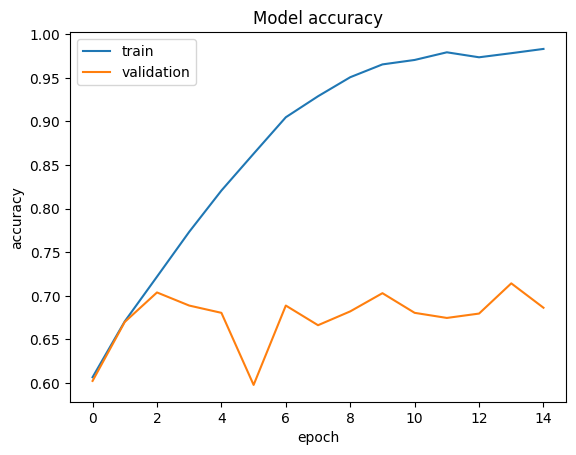

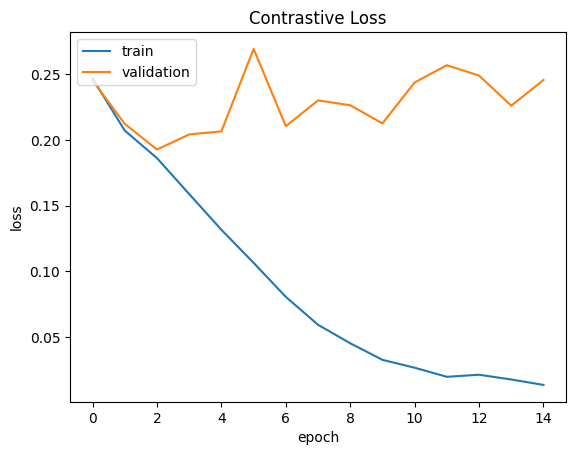

In [32]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")

Siamese Model Evaluation on Test Data

In [33]:
# Create pairs and labels for test data
# Make sure to adjust this step based on your data preprocessing
# test_pairs should contain pairs of test data, and test_labels should contain corresponding labels

# Evaluate the Siamese model on the test data
test_loss, test_accuracy = siamese_model.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_labels)
# Compute test loss and accuracy by passing test data pairs to the Siamese model
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
# Print the test loss and accuracy for evaluation

54/54 [==============================] - 16s 294ms/step - loss: 0.2364 - accuracy: 0.6959
Test Loss: 0.2364046424627304, Test Accuracy: 0.6959302425384521


Visualize the predictions

54/54 [==============================] - 18s 327ms/step


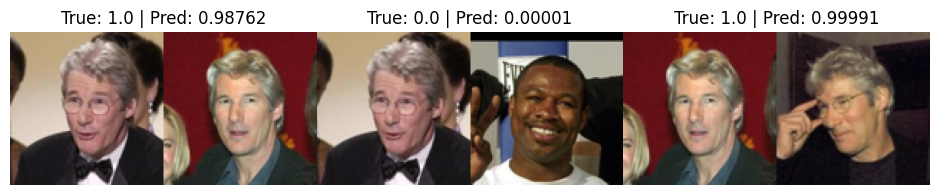

In [34]:
# Predict similarity scores for test pairs
predictions = siamese_model.predict([test_pairs[:, 0], test_pairs[:, 1]])

# Visualize test pairs and their predictions
visualize(test_pairs, test_labels, to_show=3, predictions=predictions, test=True)

RMS prop optimizer including data augmentation

In [35]:
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the Siamese model with dropout and L2 regularization
# Define a function to create the embedding model
def create_siamese_model(input_shape, dropout_rate=0.2, margin=1, l2_strength=0.01):
    # Define the embedding network
    def create_embedding_model(input_shape, l2_strength):
        input = layers.Input(input_shape)
        x = layers.Conv2D(32, (3, 3), activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(input)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = layers.Conv2D(64, (3, 3), activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = layers.Flatten()(x)
        x = layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
        return Model(input, x)

    # Create the Siamese model
    input_1 = layers.Input(input_shape)
    input_2 = layers.Input(input_shape)

    embedding_network = create_embedding_model(input_shape, l2_strength)

    tower_1 = embedding_network(input_1)
    tower_2 = embedding_network(input_2)

    merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
    normal_layer = layers.BatchNormalization()(merge_layer)
    output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
    siamese_model = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

    # Define the contrastive loss
    def loss(margin):
        def contrastive_loss(y_true, y_pred):
            square_pred = tf.math.square(y_pred)
            margin_square = tf.math.square(tf.math.maximum(margin - y_pred, 0))
            return tf.math.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)

        return contrastive_loss

    # Compile the Siamese model
    siamese_model.compile(loss=loss(margin), optimizer=RMSprop(), metrics=["accuracy"])
    return siamese_model

# Hyperparameters
epochs = 5
batch_size = 16
margin = 1
dropout_rate = 0.2
l2_strength = 0.01

# Create the Siamese model with dropout, L2 regularization, and specify margin
siamese_model = create_siamese_model((100,100, 3), dropout_rate, margin, l2_strength)
siamese_model.summary()

# Define learning rate schedules
lr_schedule1 = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001, decay_steps=1000, decay_rate=0.9)
lr_schedule2 = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001, decay_steps=1000, decay_rate=0.9)

# Compile the Siamese model with the chosen learning rate schedule
siamese_model.compile(
    loss=siamese_model.loss,
    optimizer=keras.optimizers.RMSprop(learning_rate=lr_schedule2),
    metrics=["accuracy"]
)


# Define data augmentation configuration
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Custom data generator function
def data_generator(pairs, labels, batch_size):
    while True:
        indexes = np.arange(len(pairs))
        np.random.shuffle(indexes)
        for i in range(0, len(indexes), batch_size):
            batch_indexes = indexes[i:i + batch_size]
            batch_pairs = pairs[batch_indexes]
            batch_labels = labels[batch_indexes]
            augmented_batch = []
            for pair in batch_pairs:
                augmented_pair = [datagen.random_transform(image) for image in pair]
                augmented_batch.append(augmented_pair)
            yield [np.array(augmented_batch)[:, 0], np.array(augmented_batch)[:, 1]], batch_labels

# Create data generators
train_data_generator = data_generator(train_pairs, train_labels, batch_size)
val_data_generator = data_generator(val_pairs, val_labels, batch_size)

# Train the Siamese model
history = siamese_model.fit(
    train_data_generator,
    steps_per_epoch=len(train_pairs) // batch_size,
    validation_data=val_data_generator,
    validation_steps=len(val_pairs) // batch_size,
    epochs=epochs
)




Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_14 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_8 (Functional)           (None, 128)          8720704     ['input_13[0][0]',               
                                                                  'input_14[0][0]']         

Visualize results

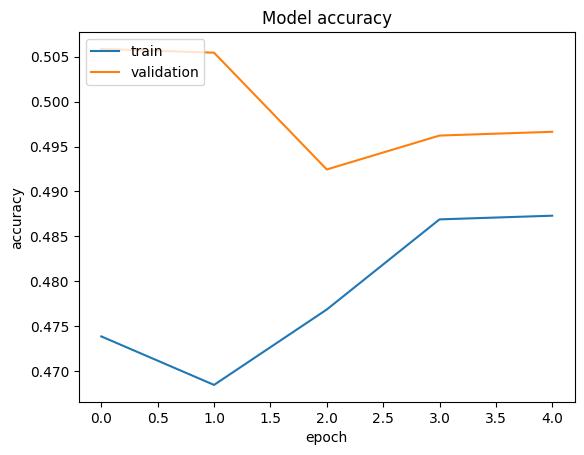

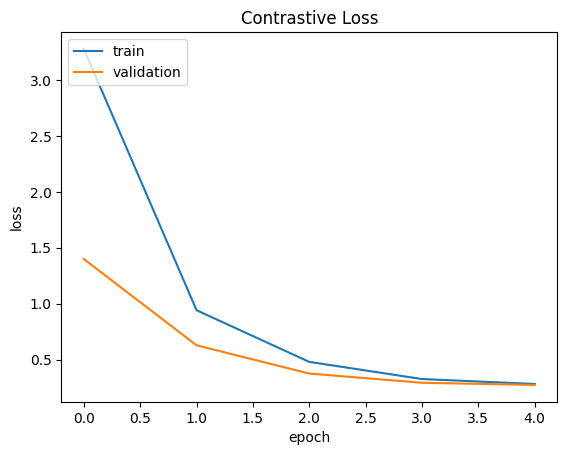

In [36]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")

In [37]:
# Evaluate the model on test data
test_loss, test_accuracy = siamese_model.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_labels)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

54/54 [==============================] - 18s 336ms/step - loss: 0.2729 - accuracy: 0.4959
Test Loss: 0.27294886112213135, Test Accuracy: 0.4959302246570587


54/54 [==============================] - 18s 318ms/step


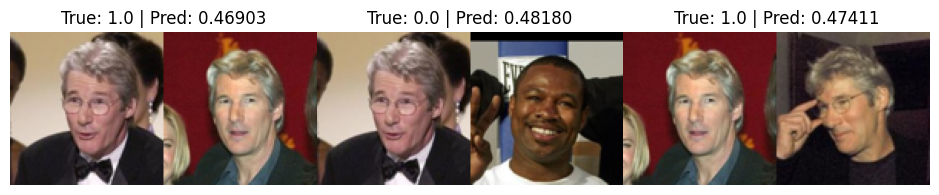

In [38]:
predictions = siamese_model.predict([test_pairs[:, 0], test_pairs[:, 1]])
visualize(test_pairs,test_labels, to_show=3, predictions=predictions, test=True)

## References:
* ### Reference for most of the code blocks from now:

    * **Siamese Contrastive** - [Keras](https://keras.io/examples/vision/siamese_contrastive/)

* most of the references are from ChatGPT and Bard which helped me find modules and helped in how to implement few functions
* other references
  * Learning Rate Schedulers and Adaptive Learning Rate Methods for Deep Learning - [link](https://towardsdatascience.com/the-best-learning-rate-schedules-6b7b9fb72565)
  * Siamese Network: Architecture, Training, and Applications - [link](https://towardsdatascience.com/siamese-networks-introduction-and-implementation-2140e3443dee)

* My friend shared me the reference he found for Siamese Network (20070063)